# Project 5 - Object Detection

### Due Date: *Friday, April 5th*

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

Please also fill in here the time that each part took you:
* 1. Part A - Feature Extraction: <span style="color:red;">1 hr</span>
* 2. Part B - Vector Quantization: <span style="color:red;">1 hr</span>
* 3. Part C - Classifier Training: <span style="color:red;">10 hr</span>
* 4. Part D - Sliding Window Detection: <span style="color:red;">10 hr</span>
* 5. Part E - Evaluation: <span style="color:red;">3 hr</span>
* 6. Challenges: <span style="color:red;">1 hr</span>
* 7. Write-up: <span style="color:red;">30 min</span>

TEAM: 
1. CODY KESLER
2. ERIC TODD
3. NEAL MUNSON


## Background - Object Detection

For this assignment, you will implement an object detection pipeline. Your project will leverage a set of training images (both positive examples where the object of interest is present and negative examples where it is not).  Your program will divide a query/test image up into image regions or _windows_ and convert each window into a feature vector representation (based on Bag-of-Words and/or HOG).  Using the training data, you will use a machine-learning algorithm to train a classification model which will predict the probability of each window (its derived feature vector, actually) containing the object to be detected.

This project will apply several of the things you’ve done previously, but also incorporate the idea of supervised machine learning.  You will need to implement both the feature extraction and the classification parts of the pipeline.  Here are the steps that you will follow:

1) Extract and cluster feature descriptors - You will extract features (feature _descriptors_) from a variety of images and cluster them into $K$ discrete clusters (visual words).

2) Vector Quantization - Given the visual vocabulary, each image is converted into a Bag-of-Words representation (a $K$-dimensional histogram).

3) Train Detection Classifier - Given the positive and negative training examples, a Support Vector Machine (SVM) is trained to distinguish between the object and everything else.

4) Sliding Window - Finds the actual object in an image by iterative considering windows at different locations and scales.


## Data

For this project, we will provide you with a dataset comprised of Butterflies and Birds/Flowers.  Your task will be to detect the birds that are present in a set of test images comprised of all three types of images.

<span style="color:red;">I will post the data tomorrow.  If you want to get started in the meantime, you can download bird images here: [CUB-200-2011 Dataset](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html).</span>

### Part A: Extract and Cluster Feature Descriptors

To create the visual vocabulary, you will need to sample (grab a subset) from amongst all the sift descriptors of a large number of images. You want a representative set of descriptors, so you should ideally grab from images of all categories you intend to recognize and also from both the set of
training images and the set of test images. A useful routine for sampling is `numpy.random.permutation(n)[0:m]` which will generate a random subset of $m$ numbers between $0$ and $n-1$. Generate a vector of column indices in this way and use it to grab a subset of $m$ columns from a given image’s descriptor matrix.

So, once you have $m$ descriptors from each image, you will concatenate these together into a single matrix. Each column is a single descriptor, so with SIFT features, this matrix has 128 rows. Let us suppose that there are a total of $M$ columns/descriptors.

Now this matrix represents $M$ distinct points in $R^{128}$. The k-means algorithm will partition these $M$ 128-dimensional points into $K$ clusters, for some value $K$ that is provided. $K$ determines how many words will be in our visual vocabulary. So, you will take his large 128 x $M$ matrix, pass it to k-means along with the desired number of clusters $K$, and kmeans will return a set of $K$ 128-dimensional points each representing the center of one of the clusters. These $K$ points form your visual vocabulary.

Resources that you may find useful:
* [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) [[Examples]](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#examples-using-sklearn-cluster-kmeans)
* [sklearn.cluster.MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)




In [173]:
import cub_dataset
import flowers_dataset
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
import os
from sklearn import svm
from scipy.misc import comb
from itertools import combinations
import cv2 as cv
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
import pickle
from sklearn.metrics import auc, roc_auc_score

In [35]:
num_imgs = 5000
CUB = cub_dataset.CUB_Dataset()
CUB_TRN = CUB.getTrainingSet()
CUB_TST = CUB.getTestSet()

FL = flowers_dataset.Flowers_Dataset()
FL_TRN = FL.getTrainingSet()
FL_TST = FL.getTestSet()

sift = cv.xfeatures2d.SIFT_create()

SET_B = ['SetB-00001.jpg','SetB-00002.jpg','SetB-00003.jpg','SetB-00004.jpg',
        'SetB-00005.jpg','SetB-00006.jpg','SetB-00007.jpg','SetB-00008.jpg',
        'SetB-00009.jpg','SetB-00010.jpg','SetB-00011.jpg','SetB-00012.jpg']

In [334]:
def extract_features():
    """
    Extracts the features for all the images in the flower and bird dataset
    :return:
    """
    i = 0
    bird_desc = []
    birds_file = 'birds' + str(num_imgs) + '.npy'
    flowers_files = 'flowers' + str(num_imgs) + '.npy'
    if (not os.path.isfile(birds_file)):
        print("Extracting Bird Features")
        for imgnum in CUB_TRN[:num_imgs]:
            i += 1
            d = CUB.getSIFTfeatures(imgnum, bbox_only=True)[1]
            random_cols = np.random.permutation(len(d))
            d = d[random_cols,:][:100]
            bird_desc.append(d)
            if(i% 500 == 0):
                print("Done with:", i)
        np.save(birds_file, bird_desc)

    print('Done loading birds features')

    i = 0
    flower_desc = []
    if(not os.path.isfile(flowers_files) ):
        print("Extracting Flower Features")
        for imgnum in FL_TRN[:num_imgs]:
            i += 1
            d = FL.getSIFTfeatures(imgnum)[1]
            random_cols = np.random.permutation(len(d))
            d = d[random_cols,:][:100]
            flower_desc.append(d)
            if (i % 500 == 0):
                print("Done with:", i)
        np.save(flowers_files, flower_desc)

    print('Done loading flower features')
    
    return np.load(birds_file), np.load(flowers_files)

### Part B: Vector Quantization - Represent each Image as a Bag-of-Words

Vector Quantization is the process of taking this visual vocabulary (the $K$ cluster centers) and converting the list of descriptors representation into a bag of visual words, a histogram identifying, for each visual word (each bin in the histogram), the fraction of the SIFT descriptors for which that visual word, or cluster center, is the closest one (in the 128-dimensional space).

Each image is thus converted using the visual vocabulary into a histogram with $K$ bins, or equivalently a feature vector with $K$ dimensions. Each descriptor in an image is mapped as a vote for the cluster whose center that given descriptor is closest to.

You can use the KMeans object you trained (fit) in Part A to predict which visual word/cluster each given descriptor is closest to.  Aggregating the cluster predictions for all descriptors in an image or window produces the Bag-of-Visual-Words representation ($K$-dimensional histogram) for the image/window.


![alt text](pipeline.png)

In [82]:
def cluster(filename, birds):
    """
    Gets the kmeans cluster object for all the training data
    :param n:
    :return:
    """

    if (not os.path.isfile(filename)):
        print('Creating and fitting kmeans object')
        kmeans = MiniBatchKMeans(n_clusters=clusters)

        fits = birds[0]
        for bird in birds:
            fits = np.vstack((fits, bird))

        kmeans.fit(fits)
        pickle.dump(kmeans, open(filename, 'wb'))

    else:
        print('Kmeans loaded from file')
        kmeans = pickle.load(open(filename, 'rb'))

    return kmeans

In [83]:
def bag_of_words(kmeans):
    """
    Gets the bag of words for each train img
    *** Modified to inculde the Color Histograms for Extra Credit***
    :param kmeans:
    :return: list of normalize histograms for each img in training set
    """
    hists = []
    labels = []

    # Get the histogram and color labels for Bird Dataset
    for i, imgnum in enumerate(CUB_TRN[:num_imgs]):
        img = CUB.getImage(imgnum)
        hist = np.histogram(kmeans.predict(birds[i]), bins=clusters, density=True)[0]
        if(color):
            hist = np.concatenate((hist, np.histogram(img[:, :, 0].T, bins=255)[0]))
            hist = np.concatenate((hist, np.histogram(img[:, :, 1].T, bins=255)[0]))
            hist = np.concatenate((hist, np.histogram(img[:, :, 2].T, bins=255)[0]))

        hists.append(hist)
        labels.append(1)

    # Get the histograms and labels for the flower dataset
    for i, imgnum in enumerate(FL_TRN[:num_imgs]):
        img = FL.getImage(imgnum)
        hist = np.histogram(kmeans.predict(flowers[i]), bins=clusters, density=True)[0]
        if(color):
            hist = np.concatenate((hist, np.histogram(img[:, :, 0].T, bins=255)[0]))
            hist = np.concatenate((hist, np.histogram(img[:, :, 1].T, bins=255)[0]))
            hist = np.concatenate((hist, np.histogram(img[:, :, 2].T, bins=255)[0]))
        hists.append(hist)
        labels.append(-1)

    return np.array(hists), np.array(labels)

### Part C: Train the Detection Classifier

To perform detection, you will using supervised machine learning to train a binary classifier using the labeled data that you're given (positive image windows with the object to be detected, negative image windows without the object).  We will be using Support Vector Machines (SVMs) as our classifier for this project. To train the SVM, you provide a set of feature vectors in the form of a matrix (the size is $K$ by the total number of training images, both positive and negative) and a corresponding label vector (generally $+1$ at the indices where the feature vector is from the positive set and $-1$ corresponding to the indices of the negative feature vectors).

Resources that you may find useful:
* [Support Vector Machines (sklearn.svm)](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
    * [User Guide](https://scikit-learn.org/stable/modules/svm.html#svm) and  [Tips on Practical Use](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use)
    * [Another Tutorial](https://www.learnopencv.com/svm-using-scikit-learn-in-python/)
* [OpenCV SVM Class](https://docs.opencv.org/3.4.1/d1/d2d/classcv_1_1ml_1_1SVM.html)
    * [OpenCV SVM Tutorial](https://docs.opencv.org/3.4/d3/d02/tutorial_py_svm_index.html)



In [375]:
def support_vector_machine(filename, prob):
    """
    Trains the support vector machine wih the given feature space from the images
    :param histos:
    :return:
    """
    if (not os.path.isfile(filename)):
        print('Loading Bags of Words...')
        # Get histograms and labels
        hists, labels = bag_of_words(kmeans)
        
        print('Fitting SVC model...')
        
#         SVC = svm.SVC(kernel = 'rbf', C = 100, gamma = 10, degree = 3)
        SVC = svm.LinearSVC()
        SVC.fit(hists, labels)

        
        print('SVC Model Saved')
        pickle.dump(SVC, open(filename, 'wb'))
    else:
        print('Loaded from file:', filename)
        SVC = pickle.load(open(filename, 'rb'))

    return SVC

In [376]:
# prob = True
# filename = 'svc_prob_no_color.sav'
# svc = support_vector_machine(filename)

### Part D: Sliding Window Detection

Detection means also finding the location of an object in an image.  Therefore, the classifier, which was trained in part C, needs to be used on a sliding window accross the image. Each window or slice of the image is run through the classifier and the windows with the highest confidence for containing the object is marked with a bounding box.

Remember that you will need to determine a detection threshold and, moreover, perform Non-maximal Suppresssion (NMS) to eliminate multiple detections of the same bird.  Also remember that it's up to you what set of scales you use for your sliding window, and likewise whether you use a "stride" to skip a few pixels each time between windows.

![alt text](sliding-window.gif)

In [377]:
def detect_A(svc):
    """
    Detect wether or not the img is a bird or not
    :param svc:
    :return:
    """
    true_pos = 0
    false_neg = 0
    predicts = []
    labels = []

    true_neg = 0
    false_pos = 0

    print('Testing Brid Imgs...')
    for imgnum in CUB_TST[100:]:
        img = CUB.getImage(imgnum)
        f, d = CUB.getSIFTfeatures(imgnum)

        hist = np.histogram(kmeans.predict(d), bins=clusters, density=True)[0]
        if(color):
            hist = np.concatenate((hist, np.histogram(img[:, :, 0].T, bins=255)[0]))
            hist = np.concatenate((hist, np.histogram(img[:, :, 1].T, bins=255)[0]))
            hist = np.concatenate((hist, np.histogram(img[:, :, 2].T, bins=255)[0]))

        predict = svc.decision_function(np.array([hist]))[0]
        predicts.append(predict)
        labels.append(1)
        if(predict > 0):
            true_pos += 1
        else:
            false_neg += 1
            

    print('Testing Flower Imgs...')
    for imgnum in FL_TST[100:]:
        img = FL.getImage(imgnum)
        f, d = FL.getSIFTfeatures(imgnum)
        hist = np.histogram(kmeans.predict(d), bins=clusters, density=True)[0]
        if(color):
            hist = np.concatenate((hist, np.histogram(img[:, :, 0].T, bins=255)[0]))
            hist = np.concatenate((hist, np.histogram(img[:, :, 1].T, bins=255)[0]))
            hist = np.concatenate((hist, np.histogram(img[:, :, 2].T, bins=255)[0]))

        predict = svc.decision_function(np.array([hist]))[0]
        predicts.append(predict)
        labels.append(-1)
        if(predict <= 0):
            true_neg += 1
        else:
            false_pos += 1

    print('True Positive:', true_pos / len(CUB_TST))
    print('False Negative:', false_neg / len(CUB_TST))
    print('True Negative:', true_neg / len(FL_TST))
    print('Fale Positive:', false_pos / len(FL_TST))

    return predicts, labels

In [378]:
def detect_B(svc, threshold, imgs):
    """
    Sliding window detection
    :param svc:
    :return:
    """
    ratios = np.array([7, 6, 5, 4, 3])
    scale = .5
    
    for img in imgs:
        h, w, c = img.shape
        img = cv.resize(img, (h//2, w//2))[:,:,::-1]
        h, w, c = img.shape
        w_h = (w / ratios).astype('int')
        w_w = (w / ratios).astype('int')

        windows = []
        probs = []
        for i in range(len(ratios)):
            for y in range(0, h, int(w_h[i] * 1/3)):
                for x in range(0, w, int(w_w[i]* 1/3)):
                    window = img[y:y+w_h[i], x:x+w_w[i], :]
                    f, d = sift.detectAndCompute(window, None)
                    if(d is not None):
                        hist = np.histogram(kmeans.predict(d), bins=clusters, density=True)[0]
                        if(color):
                            hist = np.concatenate((hist, np.histogram(window[:, :, 0].T, bins=255)[0]))
                            hist = np.concatenate((hist, np.histogram(window[:, :, 1].T, bins=255)[0]))
                            hist = np.concatenate((hist, np.histogram(window[:, :, 2].T, bins=255)[0]))
                        predict_prob = svc.decision_function(np.array([hist]))[0]
                        probs.append(predict_prob)
                        windows.append((y, y+w_h[0], x, x+w_w[1]))

        filter_boxes(img, np.array(windows), probs, threshold)
    return

In [379]:
def filter_boxes(img, windows, probs, threshold):
    """
    :param imgnum:
    :return:
    """
    # Sort the windows by the highest probability
    order = np.array(list(reversed(np.argsort(probs, axis=0))))
    probs = np.array(list(reversed(np.sort(probs))))
    windows = windows[order]

    mask = probs > threshold
    windows = windows[mask]
    probs = probs[mask]
    
    mask1 = np.array([True]*len(probs))
        
    for i, window in enumerate(windows):
        if(mask1[i]):
            boxA = window
            boxAArea = (boxA[1] - boxA[0]) * (boxA[3] - boxA[2])

            #Compare it to the rest of the boxes
            for j, boxB in enumerate(windows):
                # Get the edges of the intersecting box
                top_max = max(boxA[0], boxB[0])
                bottom_min = min(boxA[1], boxB[1])
                left_max = max(boxA[2], boxB[2])
                right_min = min(boxA[3], boxB[3])

                # Find the Area of intersection
                interseciton = (bottom_min - top_max) * (right_min - left_max)

                # Get Area of the comparing boxes
                boxBArea = (boxB[1] - boxB[0]) * (boxB[3] - boxB[2])

                # Calcualte the intersection / union
                iou = interseciton / float(boxAArea + boxBArea - interseciton)
                if (iou >= .2):
                    if(boxBArea > boxAArea):
                        mask1[i] = False
                        mask1[j] = True
                        boxA = boxB
                        boxAArea = boxBArea
                    else:
                        mask1[j] = False
                        mask1[i]=True

    windows = windows[mask1]
    
    img = img[:,:,::-1]
    for window in windows:
        img = cv.rectangle(img, (window[2], window[0]), (window[3],window[1]), (255,0,0), 4)
    plt.imshow(img[:,:,::-1])
    plt.show()
    
    return

In [399]:
def make_pr_curve(predicts, labels):
    """
    Makes the Precision Recall Curve
    """
#     print(predictions)
    TP,FP,TN,FN, = 0,0,0,0
    precision = [1]
    recall = [0]
    
    order = np.array(list(reversed(np.argsort(predicts))))
    predicts = np.array(list(reversed(np.sort(predicts))))
#     print(labels)
#     print(order)
    sorted_labels = labels[order]
    
    for i in range(1, len(predicts)):
        threshold = predicts[i]
        TP,FP,TN,FN, = 0,0,0,0
        for i, prob in enumerate(predicts):
            if prob > threshold and sorted_labels[i] == 1:
                TP += 1
            elif prob > threshold and sorted_labels[i] == -1:
                FP += 1
            elif prob <= threshold and sorted_labels[i] == -1:
                TN += 1
            else:
                FN += 1

        precision.append(TP/(TP + FP))
        recall.append(TP/ (TP + FN))
    
    auc_val = auc(labels, predicts)
    
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    average_precision = average_precision_score(labels, predicts)
    plt.title('2-class Precision-Recall curve: AP={0:0.2f} AUC={1:0.2f}'.format(
        average_precision, auc_val))

    plt.show()
    
def pr_curve(predicts, labels):
    
    average_precision = average_precision_score(labels, predicts)
    
    precision, recall, _ = precision_recall_curve(labels, predicts)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()

### Part E: Evaluation

You will now run your sliding window detector on the test images we have provided.  Note that there are two test sets, as described here:

* Set A - This set contains <span style="color:red;">TBD</span> images, each containing either a bird or something else.  _You will not need to do sliding window on this set, Set A is to gauge the accuracy of your detector on a window by window basis, simply predict bird vs. not bird_.

* Set B - This set contains <span style="color:red;">TBD</span> images, many of them with multiple birds present.  On this set, you *will* use sliding window detection, trying to detect the locations of each bird present.

For each of the two sets you will generate a detection accuracy curve.  For Set A, you will generate a Precision-Recall curve.  For Set B, you will generate a Miss Rate vs. False Positives per Image curve.  Accuracy in both cases will be judged by the Area Under the Curve (AUC) metric.  You should use the scikit-learn's [`auc()` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc) to compute this value.  For The PR curves themselves, however, you will generate these yourself.

The student in the class with the best accuracy on each test set, as measured by AUC, will receive 20 points of extra credit.  There are two 20 point bonuses available, one for the best performance on each set.


Resources for P-R Curves that you may find useful:
* scikit-learn's page on [Precision-Recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)
* scikit-learn's [`precision-recall-curve()` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)

Note than for Set A, the highest AUC wins.  For Set B, however, the lowest AUC wins.

In [120]:
"""
This Curve is using 5000 images from each training set with a Linear SVC
"""
filename = 'new_svc_500_5000.sav'
prob=False
color=False
clusters = 500
kfile = 'kmeans_500_5000.sav'
birds, flowers = extract_features()
kmeans = cluster(kfile, birds)
svc = support_vector_machine(filename, prob)
predicts, labels = detect_A(svc)
make_pr_curve(predicts, labels)

done with birds
done with flowers
Kmeans loaded from file
Loaded from file: new_svc_500_5000.sav
Testing Brid Imgs...
Testing Flower Imgs...
True Positive: 0.7298929927511218
False Negative: 0.25284777355885396
True Negative: 0.7377450980392157
Fale Positive: 0.21323529411764705


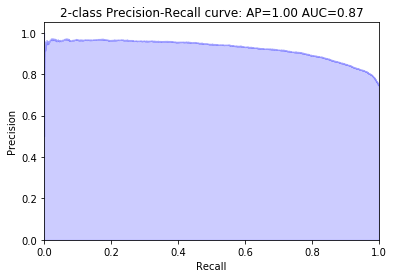

In [207]:
"""
This Curve is using 5000 images from each training set with a Linear SVC
"""
make_pr_curve(np.array(predicts), np.array(labels))

In [401]:
"""
This Curve is using 5000 images from each training set with a Linear SVC 
with COLOR HISTOGRAMS FOR EXTRA CREDIT attached while training the SVM
"""
filename = 'new_svc_500_5000_color.sav'
prob=False
color=True
clusters = 500
kfile = 'kmeans_500_5000.sav'
birds, flowers = extract_features()
kmeans = cluster(kfile, birds)
svc = support_vector_machine(filename, prob)
predicts, labels = detect_A(svc)

Done loading birds features
Done loading flower features
Kmeans loaded from file
Loaded from file: new_svc_500_5000_color.sav
Testing Brid Imgs...
Testing Flower Imgs...
True Positive: 0.8883327580255437
False Negative: 0.09440800828443217
True Negative: 0.48137254901960785
Fale Positive: 0.4696078431372549


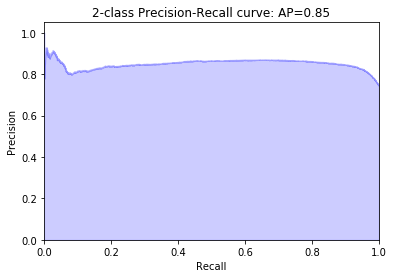

In [400]:
pr_curve(np.array(predicts), np.array(labels))

Done loading birds features
Done loading flower features
Kmeans loaded from file
Loaded from file: svc_magic.sav


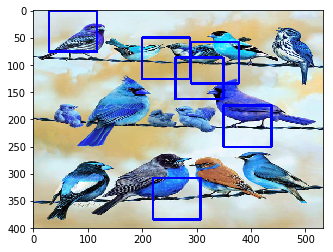

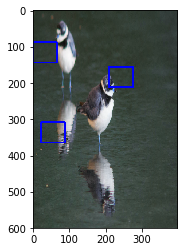

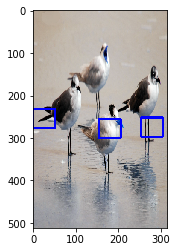

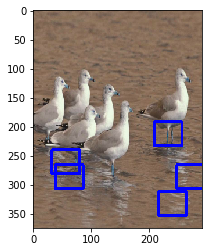

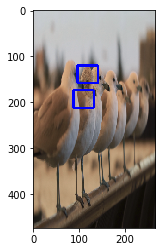

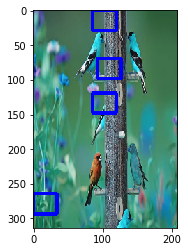

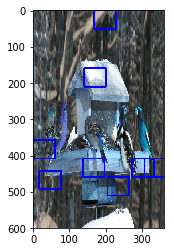

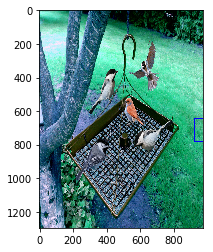

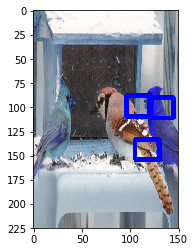

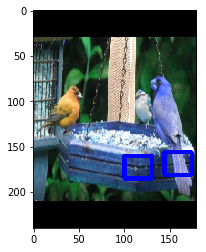

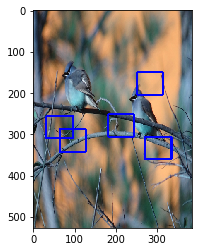

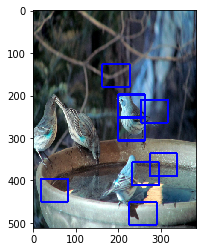

In [361]:
"""
THIS IS FOR ALL THE TEST SET B IMAGES WITH ON THRESHOLD
"""
filename = 'svc_magic.sav'
clusters = 500
kfile = 'kmeans_500_5000.sav'
prob=True
color=False
threshold = 2
birds, flowers = extract_features()
kmeans = cluster(kfile, birds)
svc = support_vector_machine(filename, prob)

imgs = []
for filename in SET_B:
    imgs.append(cv.imread('setb/' + filename)[:,:,::-1])
    
detect_B(svc, threshold, imgs)

Done loading birds features
Done loading flower features
Kmeans loaded from file
Loaded from file: svc_magic.sav
For Threshold: 1.2


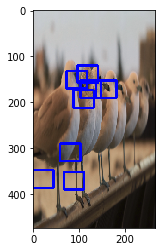

For Threshold: 1.3


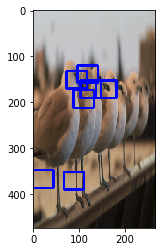

For Threshold: 1.5


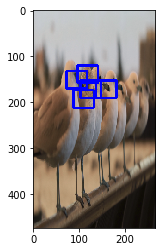

For Threshold: 1.6


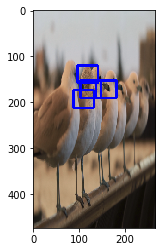

For Threshold: 1.7


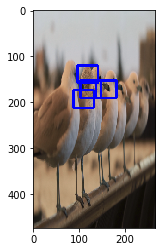

In [367]:
"""
THIS IS FOR TEST IMG 5 WITH DIFFERENT THRESHOLDS
"""
filename = 'svc_magic.sav'
clusters = 500
kfile = 'kmeans_500_5000.sav'
prob=True
color=False
thresholds = [1.2,1.3,1.5,1.6, 1.7]
birds, flowers = extract_features()
kmeans = cluster(kfile, birds)
svc = support_vector_machine(filename, prob)

imgs = []
for filename in SET_B[4:5]:
    imgs.append(cv.imread('setb/' + filename)[:,:,::-1])
    
for threshold in thresholds:
    print("For Threshold:", threshold)
    detect_B(svc, threshold, imgs)

THE  THRESHOLD EFFECT:
The tighter the threshold the less birds were found but the amount of random boxes completely vanished, so the trade off it finding more birds, but also finding more nothing.

## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Extract and Cluster Feature Descriptors.
* [20 pts] Vector Quantization - Represent each Image as a Bag-of-Words.
* [20 pts] Train the Detection Classifier.
* [20 pts] Sliding Window Detection.
* [20 pts] Evaluation

*As noted above, the person with the highest detection accuracy on each test set (Set A, Set B), will receive 20 points extra credit.*

### OPTIONAL Challenges

1) [20 points extra credit] Use color histograms to improve detection performance.  You can generate a color histogram and concatenate it onto the Bag-of-Words representation for a given image.  Concatenating features is very common.  If you choose to do this, please plot 3 curves in the same figure: the BofW by itself, the Color Histograms by themselves and the combined BoFW/ColorHist.

2) [TBD points extra credit] Other Challenges - Discuss ideas with Dr. Farrell. 




WRITE UP:

0) EXTRA CREDIT: 

We were able to tack on the color histograms for each image when training the SVM increasing the acuracy 

1) What vocabulary size gives the best results?  Does vocab size matter?

We tried various vocabulary sizes, clustering using 100, 150, 400, and 500 clusters. It seems like 500 clusters is giving us better results. That may be due to the fact that more words allows for better description of different kinds of birds. Vocab size matters a little bit, but in the ballpark around a couple 100, it seems to not make a big difference.

2) Look at some of the mistakes that your model is making (either for test set A or test set B).  Do you have any insight into why?

The training data has lots of images with birds in water, and so a lot of the test images in set B are picking up water and trying to make bouding boxes around those, since in the training, they were highly correlated with the bird images. Around the middle part of working on this lab, we were using less images to test some different implementations of support vector machines, but the use of less images also gave us less accurate results, so we decided to go back to training with more images, even though it took more time.

3) What ideas do you have for further improving your model?

One thing we could do is a grid search to find the optimal parameters for fitting the support vector machine. That way, instead of guessing and checking, we can have that automated and return to us the best parameters we could use in future models. Another thought to improve results would be to extract features while training in more central locations from within the bird bounding box to get more birdlike features that way we could reduce the effect that the water features are having in misclassifying birds.

4) Overall Thoughts

Overall, training lots of different models took a lot of time. But we feel like our algorithm did pretty well for the most part. On Test Set A, we got close to 90% accuracy, which we are happy about. However, it struggled a bit more with Test Set B, and we think part of that is becuase of the presence of so many features associated with birds that weren't exactly bird features (like water) from the training set, which happened to be present in the test set B images. Sliding window detection was harder because of that. That is, because it was producing high probabilities for things that weren't birds, our window suppression techniques struggled on some of the images. Also, I think we didn't have much time to train and work through test set B so that didn't help our ability to improve accuracy too much either.